In [1]:
import pandas as pd
from os import listdir
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# Sales Order Anonymized
soa = pd.read_csv("Tables Joined/Sales Orders anonymized.csv")
# Parcel File
pf = pd.read_csv("Tables Joined/Parcel File.csv")

C:\Users\51917\AppData\Local\Temp\ipykernel_18476\2345763794.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  soa = pd.read_csv("Tables Joined/Sales Orders anonymized.csv")
C:\Users\51917\AppData\Local\Temp\ipykernel_18476\2345763794.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  pf = pd.read_csv("Tables Joined/Parcel File.csv")


# Integrity Check Functions

In [13]:
def check_and_remove_duplicates(dataframe):
    duplicate_rows = dataframe[dataframe.duplicated()]
    print("Amount of duplicates:", len(duplicate_rows))
    # Remove duplicates
    df_no_duplicates = dataframe.drop_duplicates()
    print("duplicate rows have been removed from dataframe")
    return df_no_duplicates

In [14]:
def integrity_check(id_columns, dataframe):
    # Step 1: Share of negative values in numerical columns (excluding id columns)
    numerical_columns = [col for col in dataframe.select_dtypes(include='number').columns if col not in id_columns]
    negative_share = {}
    
    for col in numerical_columns:
        negative_count = dataframe[col][dataframe[col] < 0].count()
        total_count = len(dataframe)
        
        if negative_count > 0:
            negative_share[col] = negative_count / total_count
        else:
            negative_share[col] = 0.0

    # Step 2: Report for Text and ID columns
    text_id_columns = [col for col in dataframe.columns if pd.api.types.is_string_dtype(dataframe[col]) or col in id_columns]
    report_text_id = {}
    for col in text_id_columns:
        blanks_percentage = dataframe[col].isnull().mean() * 100
        unique_values_count = dataframe[col].nunique()
        top_values = dataframe[col].value_counts().head(10)
        top_values_percentage = (top_values / len(dataframe)) * 100
        report_text_id[col] = {'blanks_percentage': blanks_percentage,
                               'unique_values_count': unique_values_count,
                               'top_values': top_values,
                               'top_values_percentage': top_values_percentage}

    # Step 3: Report for Numerical columns
    report_numerical = {}
    for col in numerical_columns:
        blanks_percentage = dataframe[col].isnull().mean() * 100
        minimum_value = dataframe[col].min()
        average_value = dataframe[col].mean()
        median_value = dataframe[col].median()
        maximum_value = dataframe[col].max()
        report_numerical[col] = {'blanks_percentage': blanks_percentage,
                                 'minimum_value': minimum_value,
                                 'average_value': average_value,
                                 'median_value': median_value,
                                 'maximum_value': maximum_value}

    return negative_share, report_text_id, report_numerical

In [15]:
def generate_html_report(id_columns, negative_share, report_text_id, report_numerical):
    # Create an HTML report
    html_report = """
    <html>
    <head>
        <style>
            table {
                border-collapse: collapse;
                width: 100%;
            }
            th, td {
                border: 1px solid #dddddd;
                text-align: left;
                padding: 8px;
            }
            th {
                background-color: #f2f2f2;
            }
        </style>
    </head>
    <body>
    """

    # Step 0: Numerical ID Columns
    html_report += "<h2>Step 0: Numerical ID Columns</h2>"
    html_report += "<ul>"
    for col in id_columns:
        html_report += f"<li>{col}</li>"
    html_report += "</ul>"

    # Step 1: Share of Negative Values in Numerical Columns
    html_report += "<h2>Step 1: Share of Negative Values in Numerical Columns (excluding ID columns)</h2>"
    if negative_share:
        html_report += "<ul>"
        for col, share in negative_share.items():
            html_report += f"<li>{col}: {share * 100:.2f}%</li>"
        html_report += "</ul>"
    else:
        html_report += "<p>No negative values found.</p>"

    # Step 2: Report for Text and ID Columns
    html_report += "<h2>Step 2: Report for Text and ID Columns</h2>"
    for col, report in report_text_id.items():
        html_report += f"<h3>{col}</h3>"
        html_report += f"<p>Blanks Percentage: {report['blanks_percentage']:.2f}%</p>"
        html_report += f"<p>Unique Values Count: {report['unique_values_count']}</p>"
        html_report += "<p>Top 10 Values with Percentage:</p>"
        html_report += "<table>"
        html_report += "<tr><th>Value</th><th>Percentage</th></tr>"
        for value, percentage in zip(report['top_values'].index, report['top_values_percentage']):
            html_report += f"<tr><td>{value}</td><td>{percentage:.2f}%</td></tr>"
        html_report += "</table>"

    # Step 3: Report for Numerical Columns (consolidated table)
    html_report += "<h2>Step 3: Report for Numerical Columns</h2>"
    html_report += "<table>"
    html_report += "<tr><th>Column Name</th><th>Blanks Percentage</th><th>Minimum Value</th><th>Average Value</th><th>Median Value</th><th>Maximum Value</th></tr>"
    for col, report in report_numerical.items():
        html_report += f"<tr><td>{col}</td><td>{report['blanks_percentage']:.2f}%</td><td>{report['minimum_value']}</td><td>{report['average_value']}</td><td>{report['median_value']}</td><td>{report['maximum_value']}</td></tr>"
    html_report += "</table>"

    # Close the HTML report
    html_report += """
    </body>
    </html>
    """

    return html_report

In [16]:
def generate_plots(dataframe,id_columns):
    numerical_columns = [col for col in dataframe.select_dtypes(include='number').columns if col not in id_columns]
    
    # Display boxplots for numerical columns
    for col in numerical_columns:
        plt.figure(figsize=(10, 6))
        plt.boxplot(dataframe[col], vert=False)
        plt.title(f'Boxplot for {col}')
        plt.show()

# Integrity Check: Sales Orders Anonymized

In [17]:
# check top 5 rows
soa.head()

,DOMU,DOWH,DOWHD,DOSTKY,DOSTMU,DOORD#,DOSUFX,DOPART,DOQTY,DOSUM,DOORIG,DODTYP,DODYMD,DOSVAL,DOCURC,DOCUST,VALUE €
0,31,NL,WarehouseNL1,312160,30,100068,2,SKU71623,1,EA,NaN,NaN,220411,0.0075,EU,NaN,0.006919
1,31,NL,WarehouseNL1,334000,33,100076,0,SKU45337,1,PR,NaN,NaN,220113,16.3875,EU,NaN,15.117469
2,31,NL,WarehouseNL1,32A600,33,100132,0,SKU41144,2,EA,OASIS,Y,220304,24.1425,EU,NaN,22.271456
3,31,NL,WarehouseNL1,32A600,33,100132,0,SKU41145,1,EA,OASIS,Y,220304,12.0750,EU,NaN,11.139188
4,31,NL,WarehouseNL1,32A600,33,100132,0,SKU41151,1,EA,OASIS,Y,220304,12.0750,EU,NaN,11.139188


In [18]:
# Collect the names of the numerical id columns to exclude from analysis
# (this is a step that only has to be done once)
id_columns = ["DOMU","DOSTMU","DOORD#","DODYMD"]

In [20]:
# Check and remove duplicates
soa_no_duplicates = check_and_remove_duplicates(soa)

Amount of duplicates: 63577
duplicate rows have been removed from dataframe


Value,Percentage
44,59.57%
31,40.43%
Value,Percentage
NL,40.36%
UK,39.91%
RC,7.00%
DV,3.01%
LG,2.44%
QM,1.58%
UA,1.31%


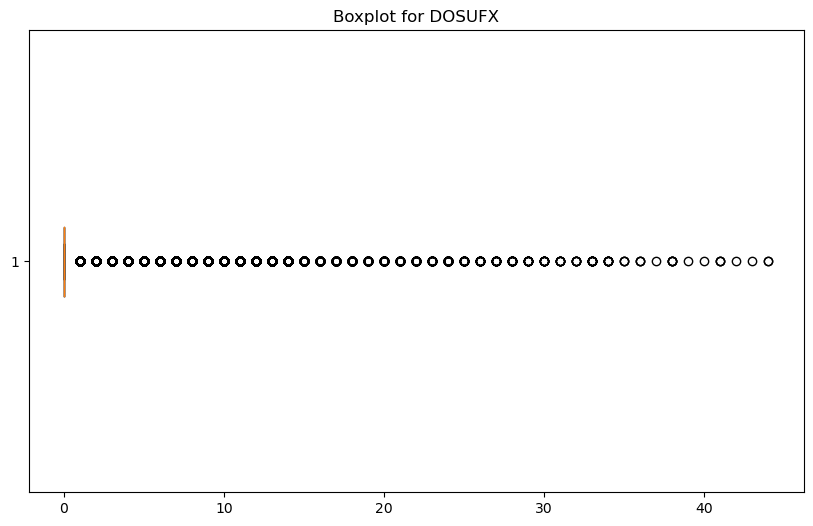

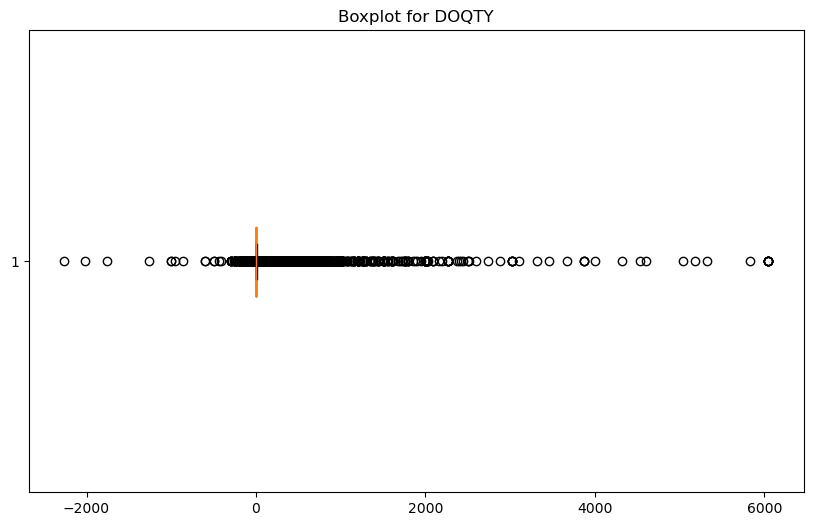

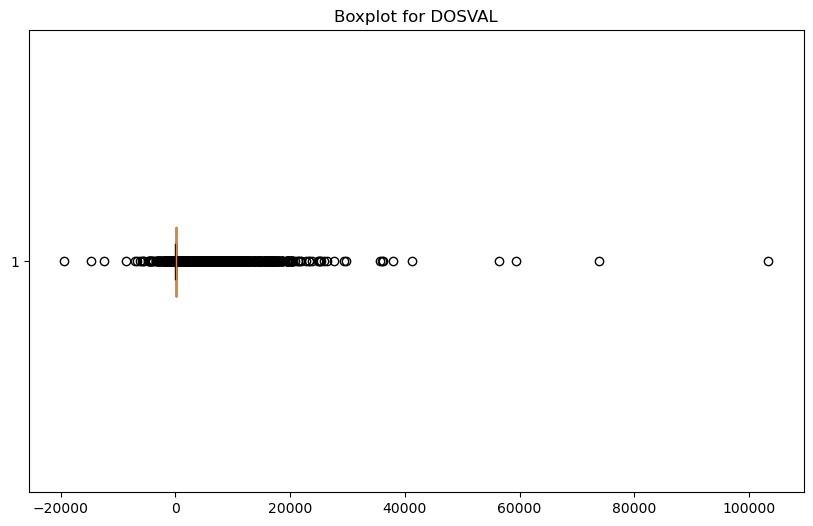

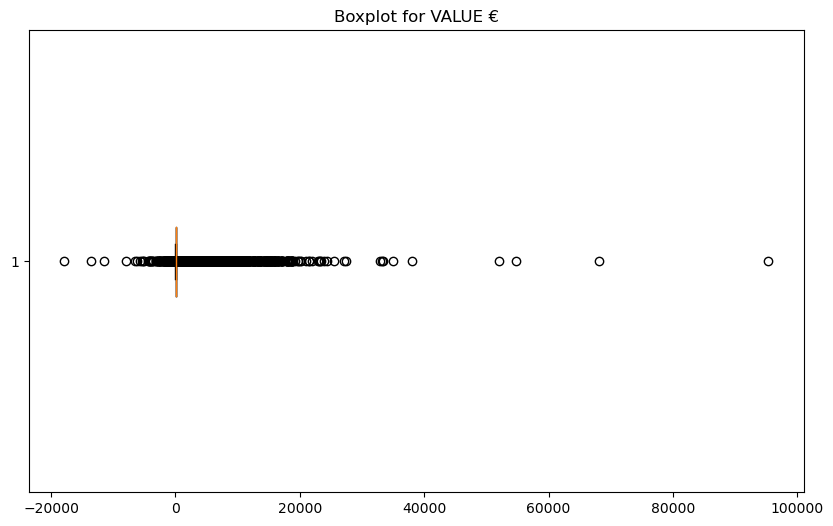

<IPython.core.display.HTML object>

In [21]:
# INTEGRITY CHECK FOR SOA

# Perform integrity check
negative_share, report_text_id, report_numerical = integrity_check(id_columns, soa_no_duplicates)

# Generate HTML report
html_report = generate_html_report(id_columns, negative_share, report_text_id, report_numerical)

# Display the HTML report in Jupyter Notebook
display(HTML(html_report))

# Generate and display the plots
html_plots = generate_plots(soa_no_duplicates,id_columns)
display(HTML(html_plots))

# Integrity Check: Parcel File

In [22]:
# check top 5 rows
pf.head()

,DAMU,DAORD#,DASUFX,DACARR,DAPARN,DACTRY,DAFRTT,DASERC,DASERD
0,31,106457,2,NLD,5228916320361,FR,XWK,101.0,NaN
1,31,106457,2,NLD,5228916320361,FR,XWK,101.0,NaN
2,31,106457,2,NLD,5228916320361,FR,XWK,101.0,NaN
3,31,112788,1,NLD,5228916309387,FR,XWK,101.0,NaN
4,31,112788,1,NLD,5228916309387,FR,XWK,101.0,NaN


In [23]:
# Collect the names of the numerical id columns to exclude from analysis
# (this is a step that only has to be done once)
id_columns = ["DAMU","DAORD#","DASUFX","DAPARN","DASERC"] 

In [24]:
pf_no_duplicates = check_and_remove_duplicates(pf)

Amount of duplicates: 375712
duplicate rows have been removed from dataframe


In [25]:
# INTEGRITY CHECK FOR SAO

# Perform integrity check
negative_share, report_text_id, report_numerical = integrity_check(id_columns, pf_no_duplicates)

# Generate HTML report
html_report = generate_html_report(id_columns, negative_share, report_text_id, report_numerical)

# Display the HTML report in Jupyter Notebook
display(HTML(html_report))

# Generate and display the plots
html_plots = generate_plots(pf_no_duplicates,id_columns)
display(HTML(html_plots))

Value,Percentage
44,96.79%
31,3.21%
Value,Percentage
0,0.83%
559377,0.03%
966840,0.03%
416159,0.02%
393573,0.02%
601198,0.02%
448230,0.02%


<IPython.core.display.HTML object>